# Import libraries

In [1]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 61.7 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 37.9 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.7 MB/s eta 0:00:0031m119.2 MB/s eta 0:00:01
  Using cached numpy-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 84.4 MB/s eta 0:00:0031m121.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:000m eta 0:00:01


In [2]:
!pip install xmltodict

  Using cached xmltodict-0.14.2-py2.py3-none-any.whl (10.0 kB)


In [3]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 29.1 MB/s eta 0:00:00m eta 0:00:010:01:01


In [1]:
import xmltodict
from matplotlib import pyplot as plt
import json
import cv2

# Read and parse xml to python dictionary

In [2]:
# B data extraction
with open("viper-annotations/video1_jorge_carros_buses.xgtf", "rb") as f:
  B1_dict = xmltodict.parse(f)

with open("viper-annotations/video1_jorge_motos.xgtf", "rb") as f:
  B2_dict = xmltodict.parse(f)

B_annotations = B1_dict["viper"]["data"]["sourcefile"]["object"] + B2_dict["viper"]["data"]["sourcefile"]["object"]

# C data extraction
with open("viper-annotations/lcarrosfinal.xgtf", "rb") as f:
  C1_dict = xmltodict.parse(f)

with open("viper-annotations/lmotosybuses.xgtf", "rb") as f:
  C2_dict = xmltodict.parse(f)

with open("viper-annotations/etiquetado.xgtf", "rb") as f:
  C3_dict = xmltodict.parse(f)

with open("viper-annotations/VideoF.xgtf", "rb") as f:
  C4_dict = xmltodict.parse(f)

C_annotations = C1_dict["viper"]["data"]["sourcefile"]["object"] + C2_dict["viper"]["data"]["sourcefile"]["object"]

In [3]:
# transforms the index from 1 to 6600, so it matches the image filenames
def n_to_int(frame, intervals):
  for i, j in intervals:
    if j - i + 1 >= frame:
      return i + frame - 1
    else:
      frame -= (j - i + 1)
  
B_intervals = [(21854, 28353)]
C_intervals = [(6705, 8904), (10056, 12255), (20112, 22311)]

In [4]:
# shows annotated image

def showAnnotated(img_file, annotation_file):
  img = cv2.imread(img_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  with open(annotation_file, "rb") as f:
    annotations_dict = xmltodict.parse(f)

  annotations = annotations_dict["annotation"]["object"]

  for ann in annotations:
    start_point = (int(float(ann["bndbox"]["xmin"])), int(float(ann["bndbox"]["ymin"])))
    end_point = (int(float(ann["bndbox"]["xmax"])), int(float(ann["bndbox"]["ymax"])))

    if ann["name"] == "car":
      color = (255, 0, 0)
    elif ann["name"] == "motorbike":
      color = (0, 255, 0)
    else:
      color = (0, 0, 255)

    img = cv2.rectangle(img, start_point, end_point, color, 2)
  plt.figure(figsize=(16, 9))
  plt.imshow(img)

## Dataset B

In [10]:
# creates a list with the annotations of every image
annotations_B = []

for i in range(6500):
  frame_string = str(n_to_int(i+1, intervals=B_intervals))
  str_len = len(frame_string)
  if str_len < 6:
    frame_string = (6 - str_len)*"0" + frame_string

  annotations_B.append({
    "annotation": {
      "folder": "v1",
      "filename": f"v1_{frame_string}.jpg",
      "source": {
        "database": "Unknown",
        "annotation": "Unknown",
        "image": "Unknown"
      },
      "size": {
        "width": 3840,
        "height": 2160,
        "depth": ""
      },
      "segmented": 0,
      "object": []
    }
  })

In [21]:
# this is to get the max id of each class, since cvat doesnt allow repeated track ids, even if the classes are different
B_car_id = []
B_bus_id = []
B_motorbike_id = []

for obj in B_annotations:
  obj_class = obj["@name"] if obj["@name"] != "moto" else "motorbike"
  obj_id = int(obj["@id"])

  if obj_class == "car":
    B_car_id.append(obj_id)
  if obj_class == "bus":
    B_bus_id.append(obj_id)
  if obj_class == "motorbike":
    B_motorbike_id.append(obj_id)

In [22]:
B_max_car_id = int(B_car_id[-1]) + 1
B_max_bus_id = int(B_bus_id[-1]) + 1

In [23]:
# cars, buses and motorbike

for obj in B_annotations:
  obj_class = obj["@name"] if obj["@name"] != "moto" else "motorbike"

  obj_id = int(obj["@id"]) + 1
  if obj_class == "bus":
    obj_id += B_max_car_id
  
  if obj_class == "motorbike":
    obj_id += B_max_car_id + B_max_bus_id

  for att in obj["attribute"]:
    if att["@name"] == "bbox":
      for ann in att["data:bbox"]:
        i_frame, j_frame = ann["@framespan"].split(":")
        i_frame = int(i_frame)
        j_frame = int(j_frame)

        height = int(ann["@height"])
        width = int(ann["@width"])
        x = int(ann["@x"])
        y = int(ann["@y"])

        xmin = x * 3840 / 1920
        ymin = y * 2160 / 1080
        xmax = (x + width) * 3840 / 1920
        ymax = (y + height) * 2160 / 1080
        
        for curr_frame in range(i_frame, j_frame+1):
          keyframe = "True" if curr_frame == i_frame else "False"

          annotations_B[curr_frame - 1]["annotation"]["object"].append({
            "name": obj_class,
            "truncated": 0,
            "occluded": 0,
            "difficult": 0,
            "bndbox": {
              "xmin": xmin,
              "ymin": ymin,
              "xmax": xmax,
              "ymax": ymax
            },
            "attributes": {
              "attribute": [
                {
                  "name": "rotation",
                  "value": 0.0,
                },
                {
                  "name": "track_id",
                  "value": obj_id,
                },
                {
                  "name": "keyframe",
                  "value": keyframe
                }
              ]
            }
          })

### Write each Pascal VOC 1.1 .xml file

In [24]:
imagesets = ""
for i in range(len(annotations_B)):
  filename, _ = annotations_B[i]["annotation"]["filename"].split(".")
  imagesets += filename + "\n"
  filename = filename + ".xml"
  with open(f"pascal-annotations/B_dataset/Annotations/{filename}", "w") as f:
    xmlstring = xmltodict.unparse(annotations_B[i], pretty=True)
    f.write(xmlstring)

### Write each filename in a .txt file

In [25]:
with open("pascal-annotations/B_dataset/ImageSets/Main/default.txt", "w") as f:
  f.write(imagesets)

## Dataset C

In [98]:
def xgftToPascal(xgft_lists, frame_ranges, folder_preffix="v2"):

  pascal_annotations = []

  for init_frame, last_frame in frame_ranges:
    for i in range(last_frame - init_frame + 1):
      frame_string = str(init_frame + i)
      str_len = len(frame_string)
      if str_len < 6:
        frame_string = (6 - str_len)*"0" + frame_string

      pascal_annotations.append({
        "annotation": {
          "folder": folder_preffix,
          "filename": f"{folder_preffix}_{frame_string}.jpg",
          "source": {
            "database": "Unknown",
            "annotation": "Unknown",
            "image": "Unknown"
          },
          "size": {
            "width": 3840,
            "height": 2160,
            "depth": ""
          },
          "segmented": 0,
          "object": []
        }
      })

  # max ids to 
  max_car_id = 0
  max_motorbike_id = 0
  max_bus_id = 0

  for viper_annotation in xgft_lists:
    for obj in viper_annotation:
      obj_class = obj["@name"] if obj["@name"] != "moto" else "motorbike"
      if obj_class == "car" or obj_class == "dcar":
        max_car_id += 1
      if obj_class == "motorbike" or obj_class == "moto" or obj_class == "dmoto":
        max_motorbike_id += 1
      if obj_class == "bus" or obj_class == "dbus":
        max_bus_id += 1
      
  curr_car_id = 0
  curr_motorbike_id = 0
  curr_bus_id = 0

  zipped_list_range = zip(xgft_lists, frame_ranges)

  curr_init_frame = 0

  for viper_annotation, frame_range in zipped_list_range:
    init_frame, last_frame = frame_range

    for obj in viper_annotation:
      obj_class = obj["@name"]

      if obj_class == "car" or obj_class == "dcar":
        obj_class = "car"
        obj_id = curr_car_id
        curr_car_id += 1
      if obj_class == "motorbike" or obj_class == "moto" or obj_class == "dmoto":
        obj_class = "motorbike"
        obj_id = max_car_id + 1 + curr_motorbike_id
        curr_motorbike_id += 1
      if obj_class == "bus" or obj_class == "dbus":
        obj_class = "bus"
        obj_id = max_car_id + max_motorbike_id + 1 + curr_bus_id
        curr_bus_id += 1

      for att in obj["attribute"]:
        if att["@name"] == "bbox":
          for ann in att["data:bbox"]:
            if type(ann) != dict:
              continue

            i_frame, j_frame = ann["@framespan"].split(":")
            i_frame = int(i_frame)
            j_frame = int(j_frame)

            height = int(ann["@height"])
            width = int(ann["@width"])
            x = int(ann["@x"])
            y = int(ann["@y"])

            xmin = x * 3840 / 1920
            ymin = y * 2160 / 1080
            xmax = (x + width) * 3840 / 1920
            ymax = (y + height) * 2160 / 1080
            
            for curr_frame in range(curr_init_frame + i_frame - 1, curr_init_frame + j_frame):
              keyframe = "True" if curr_frame == curr_init_frame + i_frame - 1 else "False"

              if curr_frame > curr_init_frame + last_frame - init_frame:
                continue

              pascal_annotations[curr_frame]["annotation"]["object"].append({
                "name": obj_class,
                "truncated": 0,
                "occluded": 0,
                "difficult": 0,
                "bndbox": {
                  "xmin": xmin,
                  "ymin": ymin,
                  "xmax": xmax,
                  "ymax": ymax
                },
                "attributes": {
                  "attribute": [
                    {
                      "name": "rotation",
                      "value": 0.0,
                    },
                    {
                      "name": "track_id",
                      "value": obj_id,
                    },
                    {
                      "name": "keyframe",
                      "value": keyframe
                    }
                  ]
                }
              })
    curr_init_frame += last_frame - init_frame + 1
  return pascal_annotations

In [90]:
# we arrange the lists of objects and ranges in an orderly manner
C_xgft_lists = [
  C1_dict["viper"]["data"]["sourcefile"]["object"] + C2_dict["viper"]["data"]["sourcefile"]["object"],
  C4_dict["viper"]["data"]["sourcefile"]["object"],
  C3_dict["viper"]["data"]["sourcefile"]["object"],
]

C_frame_ranges = [(6705, 8904), (10056, 12255), (20112, 22311)]

In [99]:
# transforms to pascal annotations and stores that in a list variable
C_annotations_pascal = xgftToPascal(C_xgft_lists, C_frame_ranges, "v2")

In [92]:
# write each pascal annotation in a xml file
imagesets = ""
for i in range(len(C_annotations_pascal)):
  filename, _ = C_annotations_pascal[i]["annotation"]["filename"].split(".")
  imagesets += filename + "\n"
  filename = filename + ".xml"
  with open(f"pascal-annotations/C_dataset/Annotations/{filename}", "w") as f:
    xmlstring = xmltodict.unparse(C_annotations_pascal[i], pretty=True)
    f.write(xmlstring)

with open("pascal-annotations/C_dataset/ImageSets/Main/default.txt", "w") as f:
  f.write(imagesets)

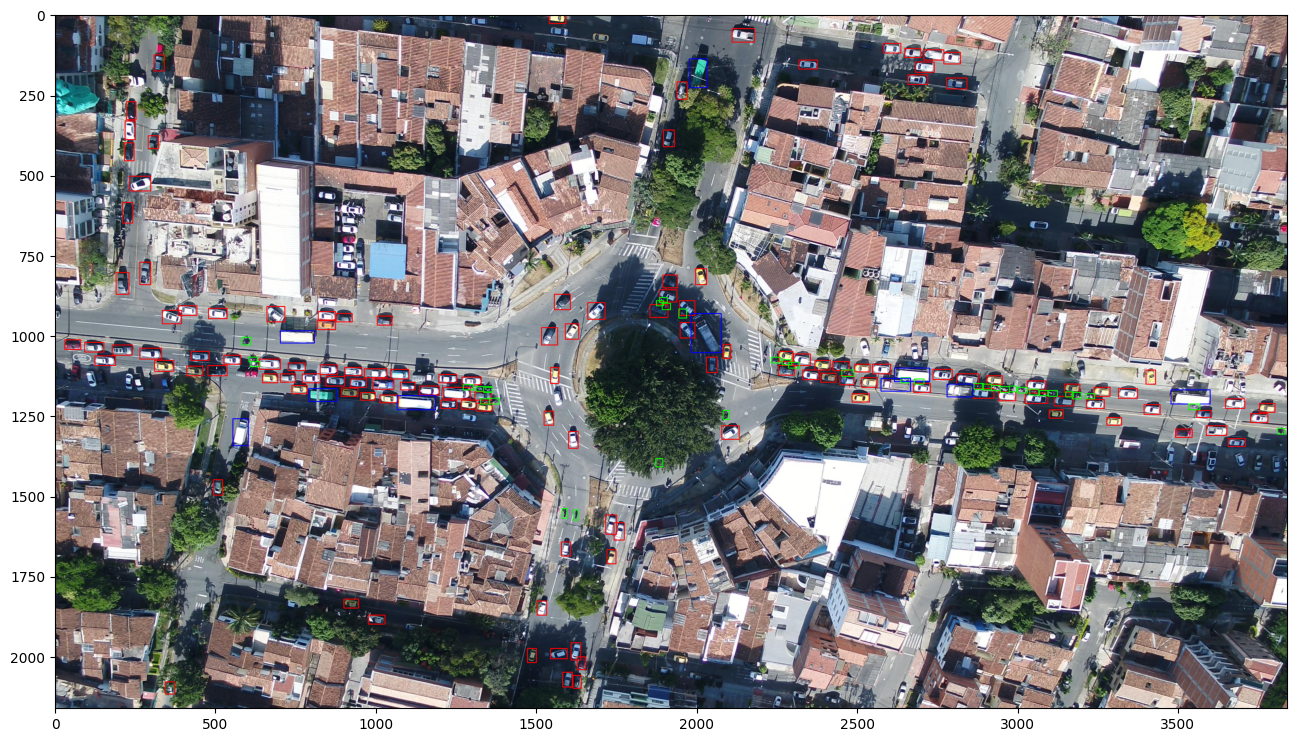

In [6]:
# show an example of annotated frame
# [(6705, 8904), (10056, 12255), (20112, 22311)]
#frame = "v2_008904"
frame = "v2_008904"
# car: red, motorbike: green, bus: blue
showAnnotated(
  f"pascal-annotations/C_dataset/JPEGImages/{frame}.jpg",
  f"pascal-annotations/C_dataset/Annotations/{frame}.xml"
)